# Example 5.8 — Measurement Error Model Development

**Author:** Justin Ryan  
**Created:** 2025-09-24  
**Updated:** 2025-11-04  
**Version:** 1.1  

---
## Problem Statement

Take the data from Table 5.16 and develop two measurement error models (additive and multiplicative) using
the MLE and Bayesian approach.

---

## Solution:

In [ ]:
# 0) Load data and basic preprocessing
# -----------------------------

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import emcee
import arviz as az
from scipy.optimize import minimize, least_squares
from scipy.special import expit  # logistic/sigmoid function
from scipy.stats import t

# --- Load and clean ---
df = pd.read_csv("Example_5.7_data.csv")

# Identify censored data (entries ending in '+')
measured_raw = df["Measured"].astype(str)
is_censored = measured_raw.str.contains(r"\+")
measured_clean = measured_raw.str.replace("+", "", regex=False)

# Convert to numeric
D_e = pd.to_numeric(measured_clean, errors="coerce")   # measured flaw size (independent)
D_m = pd.to_numeric(df["Actual"], errors="coerce")     # model flaw size (dependent)

# Drop invalid
mask = (~D_e.isna()) & (~D_m.isna())
D_e, D_m, is_censored = D_e[mask], D_m[mask], is_censored[mask]

In [18]:
# 1) Additive model LSQ: D_m = m * D_e + c + ε,   ε ~ N(0, σ_e²)
# -------------------------------------------------------------------
def residuals_add(params, x, y):
    m, c = params
    return y - (m * x + c)

p0 = [1.0, 0.0]
res_add = least_squares(residuals_add, p0, args=(D_e, D_m))
m_add, c_add = res_add.x

# sigma_e (RMSE of residuals)
resid_add = residuals_add(res_add.x, D_e, D_m)
sigma_e = np.sqrt(np.mean(resid_add**2))

# --- Book reference (Meeker et al., Example 5.7) ---
m_add_book   = 1.012
c_add_book   = 1.214
sigma_e_book = 12.798

# -------------------------------------------------------------------
# 2) Multiplicative model LSQ: ln(D_m) = m_t * ln(D_e) + c_t + ε_t
# -------------------------------------------------------------------
mask_pos = (D_e > 0) & (D_m > 0)
D_e_pos, D_m_pos = D_e[mask_pos], D_m[mask_pos]

def residuals_mult(params, x, y):
    mt, ct = params
    return np.log(y) - (mt * np.log(x) + ct)

p0 = [1.0, 0.0]
res_mult = least_squares(residuals_mult, p0, args=(D_e_pos, D_m_pos))
m_t, c_t = res_mult.x

# sigma_e_t (RMSE of log residuals)
resid_mult = residuals_mult(res_mult.x, D_e_pos, D_m_pos)
sigma_e_t = np.sqrt(np.mean(resid_mult**2))

# --- Book reference (Meeker et al., Example 5.7) ---
m_t_book   = 1.379
c_t_book   = -1.525
sigma_e_t_book = 0.635

# -------------------------------------------------------------------
# Print comparison
# -------------------------------------------------------------------
print("\n=== Additive Model Comparison ===")
print(f"{'Parameter':<12} {'This LSQ':>12} {'Book LSQ':>12} {'Difference':>14}")
print("-" * 42)
print(f"{'m':<12} {m_add:12.3f} {m_add_book:12.3f} {m_add - m_add_book:14.3f}")
print(f"{'c':<12} {c_add:12.3f} {c_add_book:12.3f} {c_add - c_add_book:14.3f}")
print(f"{'σ_e':<12} {sigma_e:12.3f} {sigma_e_book:12.3f} {sigma_e - sigma_e_book:14.3f}")

print("\n=== Multiplicative Model Comparison ===")
print(f"{'Parameter':<12} {'This LSQ':>12} {'Book LSQ':>12} {'Difference':>14}")
print("-" * 42)
print(f"{'m_t':<12} {m_t:12.3f} {m_t_book:12.3f} {m_t - m_t_book:14.3f}")
print(f"{'c_t':<12} {c_t:12.3f} {c_t_book:12.3f} {c_t - c_t_book:14.3f}")
print(f"{'σ_e_t':<12} {sigma_e_t:12.3f} {sigma_e_t_book:12.3f} {sigma_e_t - sigma_e_t_book:14.3f}")


=== Additive Model Comparison ===
Parameter        This LSQ     Book LSQ     Difference
------------------------------------------
m                   0.993        1.012         -0.019
c                   3.135        1.214          1.921
σ_e                13.905       12.798          1.107

=== Multiplicative Model Comparison ===
Parameter        This LSQ     Book LSQ     Difference
------------------------------------------
m_t                 1.391        1.379          0.012
c_t                -1.552       -1.525         -0.027
σ_e_t               0.646        0.635          0.011


In [5]:
# 2) ADDITIVE MODEL MLE:  D_m | D_e ~ N(m * D_e + c, sigma_e^2)
# ---------------------------------------------
mask_unc = ~is_censored
x_add = D_e[mask_unc].values
y_add = D_m[mask_unc].values
n_add = len(x_add)

def nll_add(params):
    m, c, log_sigma = params
    sigma = np.exp(log_sigma)  # enforce sigma > 0
    mu = m * x_add + c
    r = y_add - mu
    # Gaussian negative log-likelihood
    return 0.5 * np.sum((r / sigma)**2 + np.log(2*np.pi) + 2*log_sigma)

# Initialize from LSQ
p0_add = np.array([m_add, c_add, np.log(max(sigma_e, 1e-6))])
res_mle_add = minimize(nll_add, p0_add, method="L-BFGS-B")
m_add_mle, c_add_mle, log_sigma_add_mle = res_mle_add.x
sigma_e_mle = np.exp(log_sigma_add_mle)

print("\n=== Additive Model MLE ===")
print(f"m (MLE)     = {m_add_mle:.4f}")
print(f"c (MLE)     = {c_add_mle:.4f}")
print(f"sigma_e MLE = {sigma_e_mle:.4f}")

# Predicted curve for additive MLE
xg = np.linspace(D_e.min(), D_e.max(), 400)
y_add_mle = m_add_mle * xg + c_add_mle

# ---------------------------------------------
# 2) MULTIPLICATIVE MODEL MLE: ln(D_m) | ln(D_e) ~ N(m_t * ln(D_e) + c_t, sigma_{e_t}^2)
# ---------------------------------------------
mask_pos_unc = (~is_censored) & (D_e > 0) & (D_m > 0)
x_mult = np.log(D_e[mask_pos_unc].values)
y_mult = np.log(D_m[mask_pos_unc].values)
n_mult = len(x_mult)

def nll_mult(params):
    mt, ct, log_sigma_t = params
    sigma_t = np.exp(log_sigma_t)
    mu = mt * x_mult + ct
    r = y_mult - mu
    return 0.5 * np.sum((r / sigma_t)**2 + np.log(2*np.pi) + 2*log_sigma_t)

# Initialize from LSQ on log-space
p0_mult = np.array([m_t, c_t, np.log(max(sigma_e_t, 1e-6))])
res_mle_mult = minimize(nll_mult, p0_mult, method="L-BFGS-B")
m_t_mle, c_t_mle, log_sigma_t_mle = res_mle_mult.x
sigma_e_t_mle = np.exp(log_sigma_t_mle)

print("\n=== Multiplicative Model MLE ===")
print(f"m_t (MLE)     = {m_t_mle:.4f}")
print(f"c_t (MLE)     = {c_t_mle:.4f}")
print(f"sigma_e_t MLE = {sigma_e_t_mle:.4f}")

# Predicted curve for multiplicative MLE (back-transform)
y_mult_mle = np.exp(m_t_mle * np.log(xg) + c_t_mle)



=== Additive Model MLE ===
m (MLE)     = 1.0124
c (MLE)     = 1.2137
sigma_e MLE = 12.6014

=== Multiplicative Model MLE ===
m_t (MLE)     = 1.3794
c_t (MLE)     = -1.5269
sigma_e_t MLE = 0.6323


In [17]:
# ADDITIVE constant Gaussian noise:  y = m*x + c  on (x_add, y_add) = (D_e uncensored, D_m uncensored)
# ---------------------------
xg = np.linspace(D_e.min(), D_e.max(), 400)

# Reuse MLE line for center (can also use LSQ; same slope/intercept under Gaussian errors)
yhat_add = m_add_mle * xg + c_add_mle

# OLS geometry on uncensored pairs
x_bar = x_add.mean()
Sxx   = np.sum((x_add - x_bar)**2)

# Residual std for CI (use df = n-2 with unbiased sigma for CI)
resid_add_u = y_add - (m_add_mle * x_add + c_add_mle)
n_u = len(x_add)
s_add = np.sqrt(np.sum(resid_add_u**2) / (n_u - 2))

# t critical for 90% two-sided CI
tval_add = t.ppf(1 - 0.05, df=n_u - 2)

# Standard error of mean prediction at xg
se_mean_add = s_add * np.sqrt(1/n_u + (xg - x_bar)**2 / Sxx)

# 90% CI
add_lo = yhat_add - tval_add * se_mean_add
add_hi = yhat_add + tval_add * se_mean_add

# ---------------------------
# MULTIPLICATIVE constant Gaussian noise:  ln y = mt * ln x + ct  on positive, uncensored pairs
# ---------------------------
xg_pos = xg[xg > 0]  # grid restricted to positive for log model
xlog   = x_mult              # = ln(D_e) for pos+uncensored
ylog   = y_mult              # = ln(D_m) for pos+uncensored
xglog  = np.log(xg_pos)

# Center curve (MLE)
yhat_log = m_t_mle * xglog + c_t_mle

# OLS geometry in log space
xlog_bar = np.mean(xlog)
Sxx_log  = np.sum((xlog - xlog_bar)**2)

# Residual std in log space (unbiased for CI)
resid_log = ylog - (m_t_mle * xlog + c_t_mle)
n_log = len(xlog)
s_log = np.sqrt(np.sum(resid_log**2) / (n_log - 2))

tval_log = t.ppf(1 - 0.05, df=n_log - 2)
se_mean_log = s_log * np.sqrt(1/n_log + (xglog - xlog_bar)**2 / Sxx_log)

# 90% CI in log space, then back-transform
log_lo = yhat_log - tval_log * se_mean_log
log_hi = yhat_log + tval_log * se_mean_log
mult_center = np.exp(yhat_log)
mult_lo     = np.exp(log_lo)
mult_hi     = np.exp(log_hi)

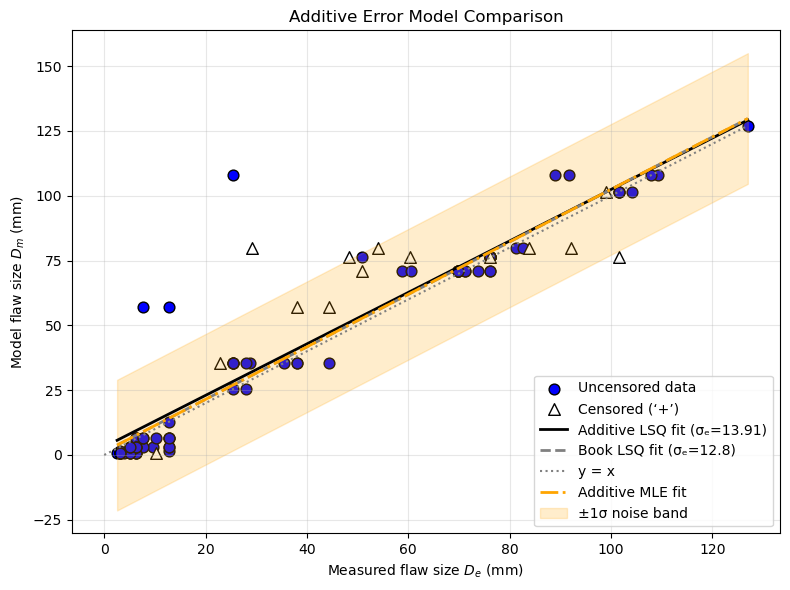

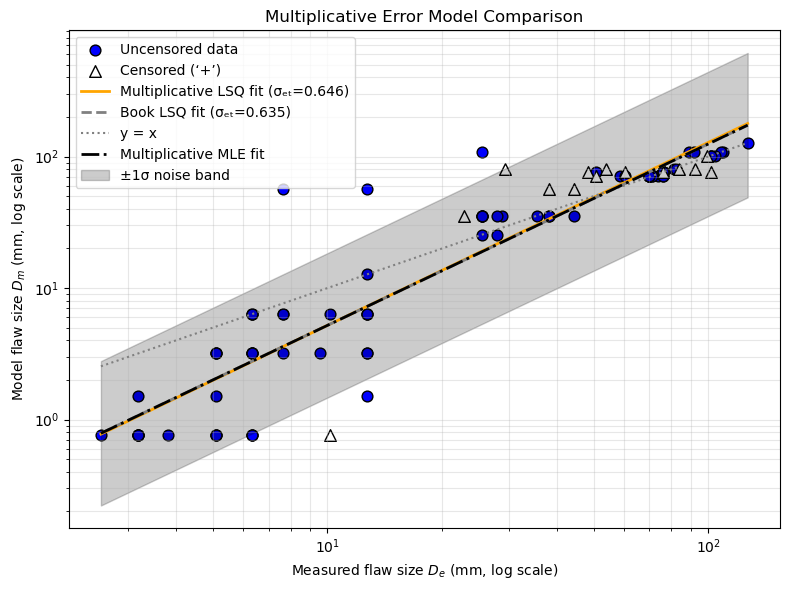

In [19]:
# 4) Parameter estimate validation visualization 
# ----------------------------------------------

# Prediction grids
x_grid = np.linspace(D_e.min(), D_e.max(), 400)
y_add_fit = m_add * x_grid + c_add
y_add_book = m_add_book * x_grid + c_add_book

y_mult_fit = np.exp(m_t * np.log(x_grid) + c_t)
y_mult_book = np.exp(m_t_book * np.log(x_grid) + c_t_book)

# Plot: Additive Model
# -------------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(D_e[~is_censored], D_m[~is_censored], s=60, color="blue", edgecolor="black", label="Uncensored data")
plt.scatter(D_e[is_censored], D_m[is_censored], s=70, facecolor="white", edgecolor="black", marker="^", label="Censored (‘+’)")
plt.plot(x_grid, y_add_fit, color="black", lw=2, label=f"Additive LSQ fit (σₑ={sigma_e:.2f})")
plt.plot(x_grid, y_add_book, color="gray", lw=2, ls="--", label=f"Book LSQ fit (σₑ={sigma_e_book:.1f})")
plt.plot([0, x_grid.max()], [0, x_grid.max()], color="gray", linestyle=":", label="y = x")
# MLE fit
y_center = m_add_mle * xg + c_add_mle
plt.plot(xg, y_center, color="orange", lw=2, ls="-.", label=f"Additive MLE fit")

# ±1σ noise band (shaded region)
plt.fill_between(xg, y_center - 2*sigma_e_mle, y_center + 2*sigma_e_mle,
                 color="orange", alpha=0.2, label="±1σ noise band")
plt.xlabel("Measured flaw size $D_e$ (mm)")
plt.ylabel("Model flaw size $D_m$ (mm)")
plt.title("Additive Error Model Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Plot: Multiplicative Model (log–log)
# -------------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(D_e_pos[~is_censored.loc[mask_pos]], D_m_pos[~is_censored.loc[mask_pos]], s=60, color="blue", edgecolor="black", label="Uncensored data")
plt.scatter(D_e_pos[is_censored.loc[mask_pos]], D_m_pos[is_censored.loc[mask_pos]], s=70, facecolor="white", edgecolor="black", marker="^", label="Censored (‘+’)")
plt.plot(x_grid, y_mult_fit, color="orange", lw=2, label=f"Multiplicative LSQ fit (σₑₜ={sigma_e_t:.3f})")
plt.plot(x_grid, y_mult_book, color="gray", lw=2, ls="--", label=f"Book LSQ fit (σₑₜ={sigma_e_t_book:.3f})")
plt.plot([x_grid.min(), x_grid.max()], [x_grid.min(), x_grid.max()], color="gray", linestyle=":", label="y = x")
# MLE central fit (log–log)
y_center_log = m_t_mle * np.log(xg_pos) + c_t_mle
y_center = np.exp(y_center_log)

# ±σ noise in log space → asymmetric bounds in linear space
y_upper = np.exp(y_center_log + 2*sigma_e_t_mle)
y_lower = np.exp(y_center_log - 2*sigma_e_t_mle)

plt.plot(xg_pos, y_center, color="black", lw=2, ls="-.", label="Multiplicative MLE fit")
plt.fill_between(xg_pos, y_lower, y_upper, color="black", alpha=0.2, label="±1σ noise band")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Measured flaw size $D_e$ (mm, log scale)")
plt.ylabel("Model flaw size $D_m$ (mm, log scale)")
plt.title("Multiplicative Error Model Comparison")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

## Answer

### Additive Measurement Error
$$
D_m = m \, D_e + c + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2)
$$

where  

| Parameter | LSQ | MLE |
|:-----------|:---:|:---:|
| $m$ | 0.993 | 1.0124 |
| $c$ | 3.135 | 1.2137 |
| $\sigma_\varepsilon$ | 13.905 | 12.601 |

---

### Multiplicative Measurement Error
$$
\ln(D_m) = m_t \, \ln(D_e) + c_t + \varepsilon_t
$$

where  

| Parameter | LSQ | MLE |
|:-----------|:---:|:---:|
| $m_t$ | 1.391 | 1.379 | 
| $c_t$ | -1.552 | -1.527 | 
| $\sigma_{\varepsilon t}$ | 0.646 | 0.632 |
